In [1]:
import json
import os
import re
import glob
import time
import numpy as np
import pandas as pd
from scipy.stats import sem
import scipy.stats as stats
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pathlib import Path
import cortex as cx
import seaborn as sns
from scipy.stats import ttest_rel, ttest_ind, ttest_1samp
from sklearn.linear_model import LinearRegression
from prf_expect.utils import io
from prf_expect.utils.fit import PRFModel, Parameters, fwhmax_fwatmin
from prf_expect.utils.beh import calculate_visual_angle
from prf_expect.utils.viz import desaturate_palette, sample_cmap, cm_to_inch
from prf_expect.utils.analysis import calc_t_stat
from matplotlib.colors import LightSource
from scipy.stats import t
from matplotlib import rc
from matplotlib import font_manager

In [2]:
glm_analysis_type = "TRMI-type1"
save_figs = True
comb_ROIs = False

In [3]:
cwd = os.getcwd()
analysis_result_dir = Path(cwd).parent / "data"
font_dirs = [Path(cwd).parent.parent / "arial"]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

rc('pdf', fonttype=42, use14corefonts=False)
rc('axes', linewidth=0.5)
rc('font',**{'family':'Arial'})
rc('text', usetex=False)
rc('xtick', labelsize=6)
rc('ytick', labelsize=6)
rc('axes', labelsize=6)
rc('legend', fontsize=6)

plt.rcParams['xtick.major.width'] = 0.5
plt.rcParams['ytick.major.width'] = 0.5
plt.rcParams['xtick.major.size'] = 2
plt.rcParams['ytick.major.size'] = 2
plt.rcParams['xtick.minor.width'] = 0.5
plt.rcParams['ytick.minor.width'] = 0.5
plt.rcParams['xtick.minor.size'] = 1
plt.rcParams['ytick.minor.size'] = 1

# set up figure parameters
markeredgecolor = ".4"
bar_linewidth = 0.5
bar_alpha = 0.7
xticks_rotation = 45
marker = "s"
marker_edge_width = 0.5
markersize = 4/2.54
errorbar_linewidth = 0.5
errorbar_capsize = 0.7/2.54
errorbar_capthick = 0.5

In [4]:
settings = io.load_settings()

Loading settings from /Users/dionysus/Library/CloudStorage/OneDrive-Personal/Workbench/pRF_expect_pub/pRF_expect_analysis/prf_expect/settings.yml


In [5]:
subjects = settings["general"]["subject_list"]
dummy_scans = settings["mri"]["dummy_scans"]
space = settings["mri"]["space"]
project_dir = os.path.join(settings["general"]["data_dir"], "data")
runs = ["01", "02", "03"]
half_vis_angle = calculate_visual_angle(settings["monitor"]["screen_size_cm"][1], 
                                        settings["monitor"]["screen_distance_cm"]) / 2
r2_thre = 0.1
print(f"Half visual angle: {half_vis_angle}")

Half visual angle: 5.723617240476087


In [6]:
# set half_vis_angle to a smaller value to avoid edge effects
half_vis_angle = 5

In [7]:
ROIs_list_long = ('V1', 'V2', 'V3', 'V3A', 'V3B', 'V4', 'LO1', 'LO2', 'VO1', 
        'VO2', 'hMT', 'MST', 'IPS0', 'IPS1', 'IPS2', 'IPS3', 'IPS4', 'IPS5')
ROIs_list_short = ["V1", "V2", "V3", "V3AB", "hV4", "LO", "TO", "VO", "IPS"]
roi_verts = cx.get_roi_verts('fsaverage', ROIs_list_long)
V1 = roi_verts['V1']
vis_verts = np.array([], dtype=int)
for roi in roi_verts:
    vis_verts = np.concatenate((vis_verts, roi_verts[roi]))

In [8]:
# norm subject number to [0,1]
def norm_subjects(subj):
    subj = np.array(subj)
    return (subj - min(subj)) / (max(subj) - min(subj))

norm_subID = norm_subjects(list(range(0, len(subjects) + 1)))

In [9]:
combined_roi_verts = {}
combined_roi_verts["V1"] = roi_verts["V1"]
combined_roi_verts["V2"] = roi_verts["V2"]
combined_roi_verts["V3"] = roi_verts["V3"]
combined_roi_verts["V3AB"] = np.concatenate((roi_verts["V3A"], roi_verts["V3B"]))
combined_roi_verts["hV4"] = roi_verts["V4"]
combined_roi_verts["LO"] = np.concatenate((roi_verts["LO1"], roi_verts["LO2"]))
combined_roi_verts["TO"] = np.concatenate((roi_verts["hMT"], roi_verts["MST"]))
combined_roi_verts["VO"] = np.concatenate((roi_verts["VO1"], roi_verts["VO2"]))
combined_roi_verts["IPS"] = np.concatenate((roi_verts["IPS0"], 
                                            roi_verts["IPS1"], 
                                            roi_verts["IPS2"], 
                                            roi_verts["IPS3"], 
                                            roi_verts["IPS4"], 
                                            roi_verts["IPS5"]))
if comb_ROIs == True:
    rois = combined_roi_verts
else:
    rois = roi_verts

ROIs_list = list(rois.keys())

In [10]:
# Define paths and data exp parameters
data_dir = Path(settings['general']['data_dir'], "data")
tasks = settings["design"]["tasks"]
space = settings["mri"]["space"]

## Load pRF results

In [11]:
# calculate IQR
def iqr(data):
    return np.nanpercentile(data, 75) - np.nanpercentile(data, 25)

In [12]:
rsq_list = []
rsq_list_2 = []
a_list = []
b_list = []
c_list = []
d_list = []
x_list = []
y_list = []
pa_list = []
ecc_list = []
prf_size_list = []
prf_hwhm_list = []
size_ratio_list = []
viol_ratio_list = []
viol_beta_spardm_list = []
viol_beta_omitdm_list = []
rsq_nanmask_list = []
viol_tstat_list = []

for subject in subjects:
    tsv_name = Path.joinpath(data_dir, 
                            "derivatives", 
                            "prf_data", 
                            subject, 
                            "ses-1", 
                            "prf_fits", 
                            "prf_params", 
                            f"{subject}_ses-1_final-fit_space-{space}_model-norm_stage-iter_desc-prf_params.tsv")
    viol_ratio_npy_name = Path.joinpath(data_dir,
                            "derivatives",
                            "prf_data",
                            subject,
                            "ses-1",
                            glm_analysis_type,
                            f"{subject}_ses-1_space-{space}_surprise-TRMI.npy")
    viol_rsq = Path.joinpath(data_dir,
                            "derivatives",
                            "prf_data",
                            subject,
                            "ses-1",
                            glm_analysis_type,
                            f"{subject}_ses-1_space-{space}_surprise-viol_rsq.npy")
    viol_beta_spardm = Path.joinpath(data_dir,
                            "derivatives",
                            "prf_data",
                            subject,
                            "ses-1",
                            glm_analysis_type,
                            f"{subject}_ses-1_space-{space}_surprise-viol_beta_sparsedm.npy")
    viol_beta_omitdm = Path.joinpath(data_dir,
                            "derivatives",
                            "prf_data",
                            subject,
                            "ses-1",
                            glm_analysis_type,
                            f"{subject}_ses-1_space-{space}_surprise-viol_beta_omitdm.npy")
    viol_tstat_npy_name = Path.joinpath(data_dir,
                            "derivatives",
                            "prf_data",
                            subject,
                            "ses-1",
                            glm_analysis_type,
                            f"{subject}_ses-1_space-{space}_surprise-viol_t_contrast.npy")
    data = pd.read_csv( 
            tsv_name,
            sep="\t",
            header=0,
        )
    mask = data["r2"] >= r2_thre
    mask_broadcasted = np.tile(mask, (data.shape[1], 1)).T
    params = data.where(mask_broadcasted)
    params_np = params.to_numpy()
    a = params["A"]
    b = params["B"]
    c = params["C"]
    d = params["D"]
    verts_nr = params["r2"].shape[0]
    
    sub_vis_rsq = np.zeros(verts_nr)
    sub_vis_rsq[:] = np.nan
    sub_vis_rsq = params["r2"]

    sub_vis_x = np.zeros(verts_nr)
    sub_vis_x[:] = np.nan
    sub_vis_x = params["x"]

    sub_vis_y = np.zeros(verts_nr)
    sub_vis_y[:] = np.nan
    sub_vis_y = params["y"]
    
    sub_vis_pa = np.zeros(verts_nr)
    sub_vis_pa[:] = np.nan
    sub_vis_pa = params["polar"]

    sub_vis_ecc = np.zeros(verts_nr)
    sub_vis_ecc[:] = np.nan
    sub_vis_ecc = params["ecc"]

    sub_vis_prf_ampl = np.zeros(verts_nr)
    sub_vis_prf_ampl[:] = np.nan
    sub_vis_prf_ampl = params["prf_ampl"]

    sub_vis_prf_size = np.zeros(verts_nr)
    sub_vis_prf_size[:] = np.nan
    sub_vis_prf_size = params["prf_size"]

    sub_vis_prf_hwhm = np.zeros(verts_nr)
    sub_vis_prf_hwhm[:] = np.nan
    sub_vis_prf_hwhm, _ = fwhmax_fwatmin("norm", params_np, normalize_RFs=False)

    sub_vis_size_ratio = np.zeros(verts_nr)
    sub_vis_size_ratio[:] = np.nan
    sub_vis_size_ratio = params["size ratio"]

    sub_vis_viol_ratio = np.load(viol_ratio_npy_name)
    sub_vis_viol_rsq = np.load(viol_rsq)
    sub_vis_viol_tstat = np.load(viol_tstat_npy_name)

    sub_vis_viol_beta_sparsedm = np.load(viol_beta_spardm)
    sub_vis_viol_beta_omitdm = np.load(viol_beta_omitdm)

    sub_vis_rsq[sub_vis_ecc>half_vis_angle] = np.nan
    sub_vis_rsq[sub_vis_prf_ampl<0.0] = np.nan
    sub_vis_rsq[sub_vis_rsq<0.0] = np.nan
    
    sub_vis_rsq_2 = sub_vis_rsq.copy()
    sub_vis_rsq_2[sub_vis_viol_rsq<0.0] = np.nan

    sub_vis_a = np.nan_to_num(a.values, copy=True, nan=0.0)
    sub_vis_b = np.nan_to_num(b.values, copy=True, nan=0.0)
    sub_vis_c = np.nan_to_num(c.values, copy=True, nan=0.0)
    sub_vis_d = np.nan_to_num(d.values, copy=True, nan=0.0)
    sub_vis_x = np.nan_to_num(sub_vis_x, copy=True, nan=0.0)
    sub_vis_y = np.nan_to_num(sub_vis_y, copy=True, nan=0.0)
    sub_vis_pa = np.nan_to_num(sub_vis_pa, copy=True, nan=0.0)
    sub_vis_prf_size = np.nan_to_num(sub_vis_prf_size, copy=True, nan=0.0)
    sub_vis_prf_hwhm = np.nan_to_num(sub_vis_prf_hwhm, copy=True, nan=0.0)
    sub_vis_size_ratio = np.nan_to_num(sub_vis_size_ratio, copy=True, nan=0.0)
    sub_vis_ecc = np.nan_to_num(sub_vis_ecc, copy=True, nan=0.0)
    
    iqr_viol_ratio = iqr(sub_vis_viol_ratio)
    sub_vis_viol_ratio[sub_vis_ecc>half_vis_angle] = 0
    sub_vis_viol_ratio[sub_vis_prf_ampl<0.0] = 0
    sub_vis_viol_ratio[sub_vis_rsq<0.0] = 0
    sub_vis_viol_ratio_masked = sub_vis_viol_ratio.copy()
    sub_vis_viol_ratio_masked[sub_vis_viol_ratio>(np.nanmedian(sub_vis_viol_ratio) + 2 * iqr_viol_ratio)] = 0
    sub_vis_viol_ratio_masked[sub_vis_viol_ratio<(np.nanmedian(sub_vis_viol_ratio) - 2 * iqr_viol_ratio)] = 0
    sub_vis_viol_ratio_masked = np.nan_to_num(sub_vis_viol_ratio_masked, copy=True, nan=0.0)
    viz_data_rsq_nanmask = ~np.isnan(sub_vis_rsq)

    iqr_vis_viol_tstat = iqr(sub_vis_viol_tstat)
    sub_vis_viol_tstat[sub_vis_viol_tstat>(np.nanmedian(sub_vis_viol_tstat) + 2 * iqr_vis_viol_tstat)] = 0
    sub_vis_viol_tstat[sub_vis_ecc>half_vis_angle] = 0
    sub_vis_viol_tstat[sub_vis_prf_ampl<0.0] = 0
    sub_vis_viol_tstat[sub_vis_rsq<0.0] = 0
    sub_vis_viol_tstat_masked = sub_vis_viol_tstat.copy()
    sub_vis_viol_tstat_masked[sub_vis_viol_tstat>(np.nanmedian(sub_vis_viol_tstat) + 2 * iqr_vis_viol_tstat)] = 0
    sub_vis_viol_tstat_masked[sub_vis_viol_tstat<(np.nanmedian(sub_vis_viol_tstat) - 2 * iqr_vis_viol_tstat)] = 0
    sub_vis_viol_tstat_masked = np.nan_to_num(sub_vis_viol_tstat_masked, copy=True, nan=0.0)
    
    
    rsq_list.append(sub_vis_rsq)
    rsq_list_2.append(sub_vis_rsq_2)
    a_list.append(sub_vis_a)
    b_list.append(sub_vis_b)
    c_list.append(sub_vis_c)
    d_list.append(sub_vis_d)
    x_list.append(sub_vis_x)
    y_list.append(sub_vis_y)
    pa_list.append(sub_vis_pa)
    ecc_list.append(sub_vis_ecc)
    prf_size_list.append(sub_vis_prf_size)
    prf_hwhm_list.append(sub_vis_prf_hwhm)
    size_ratio_list.append(sub_vis_size_ratio)

    viol_ratio_list.append(sub_vis_viol_ratio_masked)
    rsq_nanmask_list.append(viz_data_rsq_nanmask)
    viol_tstat_list.append(sub_vis_viol_tstat_masked)
    viol_beta_spardm_list.append(sub_vis_viol_beta_sparsedm)
    viol_beta_omitdm_list.append(sub_vis_viol_beta_omitdm)

rsq_list = np.array(rsq_list)
rsq_list_2 = np.array(rsq_list_2)
rsq_nanmask_list = np.array(rsq_nanmask_list)

avg_nanmask = np.any(rsq_nanmask_list, axis=0)
avg_rsq = np.nanmean(rsq_list, axis=0)
avg_rsq = np.nan_to_num(avg_rsq, copy=True, nan=0.0)
avg_rsq_2 = np.nanmean(rsq_list_2, axis=0)
avg_rsq_2 = np.nan_to_num(avg_rsq_2, copy=True, nan=0.0)
rsq_list_nonan = np.nan_to_num(rsq_list, copy=True, nan=1e-6)
rsq_list_2_nonan = np.nan_to_num(rsq_list_2, copy=True, nan=1e-6)

a_list = np.array(a_list)
avg_a = np.average(a_list, axis=0, weights=rsq_list_nonan)

b_list = np.array(b_list)
avg_b = np.average(b_list, axis=0, weights=rsq_list_nonan)

c_list = np.array(c_list)
avg_c = np.average(c_list, axis=0, weights=rsq_list_nonan)

d_list = np.array(d_list)
avg_d = np.average(d_list, axis=0, weights=rsq_list_nonan)

x_list = np.array(x_list)
avg_x = np.average(x_list, axis=0, weights=rsq_list_nonan)

y_list = np.array(y_list)
avg_y = np.average(y_list, axis=0, weights=rsq_list_nonan)

# calculate polar angle with x and y
avg_pa = np.arctan2(avg_y, avg_x)

pa_list = np.array(pa_list)

ecc_list = np.array(ecc_list)
avg_ecc = np.average(ecc_list, axis=0, weights=rsq_list_nonan)

prf_size_list = np.array(prf_size_list)
avg_prf_size = np.average(prf_size_list, axis=0, weights=rsq_list_nonan)

prf_hwhm_list = np.array(prf_hwhm_list)
avg_prf_hwhm = np.average(prf_hwhm_list, axis=0, weights=rsq_list_nonan)

size_ratio_list = np.array(size_ratio_list)
avg_size_ratio = np.average(size_ratio_list, axis=0, weights=rsq_list_nonan)

viol_ratio_list = np.array(viol_ratio_list)
avg_viol_ratio = np.average(viol_ratio_list, axis=0, weights=rsq_list_2_nonan)

viol_tstat_list = np.array(viol_tstat_list)
viol_tstat_list = np.nan_to_num(viol_tstat_list, copy=True, nan=0.0)
avg_viol_tstat = np.average(viol_tstat_list, axis=0, weights=rsq_list_2_nonan)

viol_beta_spardm_list = np.array(viol_beta_spardm_list)
viol_beta_spardm_list = np.nan_to_num(viol_beta_spardm_list, copy=True, nan=0.0)
avg_viol_beta_spardm = np.average(viol_beta_spardm_list, axis=0, weights=rsq_list_nonan)

viol_beta_omitdm_list = np.array(viol_beta_omitdm_list)
viol_beta_omitdm_list = np.nan_to_num(viol_beta_omitdm_list, copy=True, nan=0.0)
avg_viol_beta_omitdm = np.average(viol_beta_omitdm_list, axis=0, weights=rsq_list_nonan)


avg_a[~avg_nanmask] = np.nan
avg_b[~avg_nanmask] = np.nan
avg_c[~avg_nanmask] = np.nan
avg_d[~avg_nanmask] = np.nan
avg_ecc[~avg_nanmask] = np.nan
avg_viol_ratio[~avg_nanmask] = np.nan
avg_viol_tstat[~avg_nanmask] = np.nan

/var/folders/1x/nhszthp519l9hrq_yddm9yhr0000gn/T/ipykernel_22443/2746663788.py:187: RuntimeWarning: Mean of empty slice
  avg_rsq = np.nanmean(rsq_list, axis=0)
/var/folders/1x/nhszthp519l9hrq_yddm9yhr0000gn/T/ipykernel_22443/2746663788.py:189: RuntimeWarning: Mean of empty slice
  avg_rsq_2 = np.nanmean(rsq_list_2, axis=0)


In [13]:
for rois in roi_verts:
    roi_rsq = avg_rsq[roi_verts[rois]]
    print(f"ROI: {rois}, mean r2: {np.nanmean(roi_rsq):.3f}, std r2: {np.nanstd(roi_rsq):.3f}")

ROI: V1, mean r2: 0.518, std r2: 0.262
ROI: V2, mean r2: 0.522, std r2: 0.260
ROI: V3, mean r2: 0.530, std r2: 0.219
ROI: V3A, mean r2: 0.536, std r2: 0.180
ROI: V3B, mean r2: 0.566, std r2: 0.089
ROI: V4, mean r2: 0.536, std r2: 0.115
ROI: LO1, mean r2: 0.603, std r2: 0.075
ROI: LO2, mean r2: 0.533, std r2: 0.083
ROI: VO1, mean r2: 0.554, std r2: 0.082
ROI: VO2, mean r2: 0.416, std r2: 0.129
ROI: hMT, mean r2: 0.501, std r2: 0.117
ROI: MST, mean r2: 0.533, std r2: 0.080
ROI: IPS0, mean r2: 0.441, std r2: 0.087
ROI: IPS1, mean r2: 0.389, std r2: 0.094
ROI: IPS2, mean r2: 0.338, std r2: 0.106
ROI: IPS3, mean r2: 0.404, std r2: 0.095
ROI: IPS4, mean r2: 0.481, std r2: 0.097
ROI: IPS5, mean r2: 0.424, std r2: 0.064


In [14]:
figure_result_dir = Path("/Users/dionysus/Library/CloudStorage/OneDrive-Personal/Workbench/pRF_expect_pub/pRF_expect_analysis/prf_expect/analysis/figures")

## Better bar plots

In [15]:
original_gist_rainbow = plt.cm.gist_rainbow  # Original colormap
palette_desaturated_gist_rainbow = desaturate_palette(original_gist_rainbow, saturation=1)

In [16]:
gist_rainbow_desaturated = desaturate_palette(plt.colormaps.get_cmap("gist_rainbow"), saturation=0.80, lightness=0.9)
gist_rainbow_sampled = sample_cmap(gist_rainbow_desaturated, len(ROIs_list))

gist_rainbow_desaturated_2 = desaturate_palette(plt.colormaps.get_cmap("gist_rainbow"), saturation=1)
gist_rainbow_sampled_2 = sample_cmap(gist_rainbow_desaturated_2, len(ROIs_list))

gist_rainbow_desaturated_3 = desaturate_palette(plt.colormaps.get_cmap("gist_rainbow"), saturation=1.0, lightness=0.6)
gist_rainbow_sampled_3 = sample_cmap(gist_rainbow_desaturated_3, len(ROIs_list))

In [17]:
# make a palette with 4 colors
# Create an array with the colors you want to use
colors = ["#2f708e", "#f69067", "#56ab46", "#9b2c91"]
customparamPalette = sns.color_palette(sns.color_palette(colors),)
# sns.color_palette(customparamPalette)
customparamPalette_sampled = sample_cmap(customparamPalette, len(colors))

In [18]:
from matplotlib.colors import LinearSegmentedColormap
customparamPalette_desaturated = desaturate_palette(LinearSegmentedColormap.from_list("custom_cmap", 
                                                                                      customparamPalette, 
                                                                                      N=len(colors)), 
                                                    saturation=0.9, 
                                                    lightness=0.4)
customparamPalette_desaturated_sampled = sample_cmap(customparamPalette_desaturated, len(colors))

## GLM - regress TRMI against B and D

In [19]:
def iqr(data):
    return np.nanpercentile(data, 75) - np.nanpercentile(data, 25)

In [20]:
def normalize(data):
    return (data - np.mean(data)) / np.std(data)

def glm_TRMI_param(y, param, rsq, rsq_thre=0.3, normalize_data=True, with_iqr=False, vis_verts=None):
    # get the beta of param using np.linalg.lstsq
    # y: dependent variable
    # param: independent variable
    # rsq: r2 of the model
    # rsq_thre: r2 threshold

    mask = rsq >= rsq_thre
    if vis_verts is not None:
        vis_mask = np.zeros(y.shape, dtype=bool)
        print(f"Number of voxels before visual mask: {y.shape[0]}")
        vis_mask[vis_verts] = True
        mask = mask & vis_mask
    y = y[mask]
    param = param[mask, :]

    if with_iqr:
        mask = np.ones(y.shape, dtype=bool)
        for param_i in param.T:
            mask_para = np.abs(param_i - np.median(param_i)) < 1.5 * iqr(param_i)
            mask = mask & mask_para
    
    y = y[mask]
    print(f"Number of voxels: {y.shape[0]}")
    param = param[mask, :]

    if normalize_data:
        y = normalize(y)
        for i in range(param.shape[1]):
            param[:, i] = normalize(param[:, i])

    X = np.column_stack((np.ones(y.shape), param))
    beta, _, _, _ = np.linalg.lstsq(X, y, rcond=None)

    y_pred = np.dot(X, beta)

    ts = np.array([])
    ps = np.array([])
    for i in range(1, X.shape[1]):
        contrast_vector = np.zeros(X.shape[1])
        contrast_vector[i] = 1
        t, p = calc_t_stat(X, y, y_pred, beta, contrast_vector)
        ts = np.append(ts, t)
        ps = np.append(ps, p)
    return beta, ts, ps


In [21]:
r2_thre_glm = 0.3
param_list = ["b", "d", "ecc", "prf_size"]

In [22]:
betas_b = np.zeros(len(subjects))
betas_d = np.zeros(len(subjects))
betas_ecc = np.zeros(len(subjects))
betas_prf_size = np.zeros(len(subjects))

t_b = np.zeros(len(subjects))
t_d = np.zeros(len(subjects))
t_ecc = np.zeros(len(subjects))
t_prf_size = np.zeros(len(subjects))

# combine b_list, d_list, ecc_list, prf_size_list into numpy array

for i, sub in enumerate(subjects):
    params = np.array([b_list[i], d_list[i], ecc_list[i], prf_size_list[i]]).T

    betas, t, _ = glm_TRMI_param(viol_ratio_list[i], params, rsq_list[i], rsq_thre=r2_thre_glm, with_iqr=True, vis_verts=None)
    betas_b[i] = betas[1]
    betas_d[i] = betas[2]
    betas_ecc[i] = betas[3]
    betas_prf_size[i] = betas[4]
    t_b[i] = t[0]
    t_d[i] = t[1]
    t_ecc[i] = t[2]
    t_prf_size[i] = t[3]
    # print(f"Subject {sub} betas: {betas}")

# calculate t-statistics for the betas
ts_group_b = ttest_1samp(betas_b, 0)
ts_group_d = ttest_1samp(betas_d, 0)
ts_group_ecc = ttest_1samp(betas_ecc, 0)
ts_group_prf_size = ttest_1samp(betas_prf_size, 0)

print(f"Group t-statistics for beta b: {ts_group_b[0]:.4f}, p-value: {ts_group_b[1]:.4f}")
print(f"Group t-statistics for beta d: {ts_group_d[0]:.4f}, p-value: {ts_group_d[1]:.4f}")
print(f"Group t-statistics for beta ecc: {ts_group_ecc[0]:.4f}, p-value: {ts_group_ecc[1]:.4f}")
print(f"Group t-statistics for beta prf_size: {ts_group_prf_size[0]:.4f}, p-value: {ts_group_prf_size[1]:.4f}")

df_TRMI_betas = pd.DataFrame()
for betas, label in zip([betas_b, betas_d, betas_ecc, betas_prf_size], param_list):
    df_TRMI_betas = pd.concat([df_TRMI_betas, pd.DataFrame({"subject": subjects, "beta": betas, "param": label})])

Number of voxels: 33609
Number of voxels: 12849
Number of voxels: 13208
Number of voxels: 20063
Number of voxels: 24388
Number of voxels: 18110
Number of voxels: 22420
Group t-statistics for beta b: -3.9901, p-value: 0.0072
Group t-statistics for beta d: 1.2398, p-value: 0.2613
Group t-statistics for beta ecc: -0.1562, p-value: 0.8810
Group t-statistics for beta prf_size: 5.8021, p-value: 0.0011


/var/folders/1x/nhszthp519l9hrq_yddm9yhr0000gn/T/ipykernel_22443/3357453362.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["b", "d", "Eccentricity", "pRF size"], rotation=45)


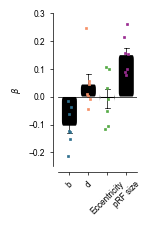

In [23]:
from matplotlib.patches import FancyBboxPatch

fig, ax = plt.subplots(figsize=cm_to_inch(4, 6))
ax = sns.barplot(data=df_TRMI_betas, x="param", y="beta", errorbar="se", color="black", ax=ax, err_kws={'color': 'black', 'linewidth': 0.5}, capsize=errorbar_capsize)
# for i, label in enumerate(param_list):
#     ax.scatter([i] * len(subjects), df_TRMI_betas[df_TRMI_betas["param"] == label]["beta"], color="black", s=5)
sns.despine(offset=4)
# ax.title.set_text(f"rsq > {r2_thre_glm}")
ax.set_ylim(-0.25, 0.3)
# ax.set_xticklabels([],)
ax.set_xlabel("")
ax.set_xticklabels(["b", "d", "Eccentricity", "pRF size"], rotation=45)
# ax.set_xlabel("pRF Parameters")
ax.set_ylabel(r"$\beta$")

new_patches = []
for patch in reversed(ax.patches):
    # print(bb.xmin, bb.ymin,abs(bb.width), abs(bb.height))
    bb = patch.get_bbox()
    color = patch.get_facecolor()
    p_bbox = FancyBboxPatch((bb.xmin, bb.ymin),
                            abs(bb.width), abs(bb.height),
                            boxstyle="round,pad=-0.0040,rounding_size=0.08",
                            ec="none", fc=color,
                            mutation_aspect=0.2
                            )
    patch.remove()
    new_patches.append(p_bbox)

for patch in new_patches:
    ax.add_patch(patch)

for ipara, param in enumerate(param_list):
    for isubject, subject in enumerate(subjects):
        pos = param_list.index(param) + (norm_subID[isubject]-0.5)*0.2
        mean_data = df_TRMI_betas[(df_TRMI_betas.param==param) & (df_TRMI_betas.subject==subject)]["beta"].values[0]
        ax.plot(pos, 
                mean_data, 
                marker=marker, 
                markeredgecolor=customparamPalette_sampled[ipara], 
                markerfacecolor=customparamPalette_sampled[ipara],
                markeredgewidth=marker_edge_width,
                markersize=markersize,
                clip_on=False,
        )
ax.axhline(0, color="black", linewidth=0.5)
plt.tight_layout()
if save_figs:
    ax.figure.savefig(figure_result_dir.joinpath(f"group_analysis-{glm_analysis_type}_space-fsaverage_TRMI_glm_parambetas_supplementary.pdf"), bbox_inches="tight", dpi=600)